# **Heart Disease Classification With a K-Nearest Neighbors Algorithm**
**Authors:** Andy Hu, Sharon Tu, Dylan Zhang, Renz Tingson

# 1. Introduction
<img src='https://raw.githubusercontent.com/andyh031/heart-disease-classification/main/images/heart.jpg' width = '400' >

Source: https://raw.githubusercontent.com/andyh031/heart-disease-classification/main/images/heart.jpg


When will we find the cure to cancer? What is the newest cutting edge medical technology? Medicine is on the forefront of innovation and advancement, with people pouring in extensive resources for research purposes. In particular, heart disease is the second leading cause of death among Canadians, with roughly 1 in 12 adults diagnosed during their lifetime ([Government of Canada](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html), 2022). Heart disease encompasses a variety of conditions affecting the cardiovasular system. The most common of these conditions include coronary heart disease, heart attacks, arrhythmias, and stroke. As such, it is crucial to detect and diagnose heart disease early to prevent long-term deficits, or potentially even death. Our research aims to find accessible ways in which we can accomplish this.

## Research Question
How well can we classify if a patient has a heart disease based on factors that can be easily monitored at home, such as age and maximum heart rate achieved? For our purposes, presence of a heart disease is indicated by greater than 50% diameter narrowing of blood vessels. 

## Dataset
We will be using the [Cleveland Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease) (Jasoni et al., 1988) dataset, which contains 14 characteristics about each patient. We will be focusing on numerical predictors rather than categorical labels, with our classification predicting a patient's condition of having a heart disease. The dataset classifies patient's heart disease on a scale from zero to four. For our purposes, we will treat the labels from one to four all as one, indicating the presence of a heart disease.

# 2. Methods & Results
We explore the dataset to discover which factors constitute the most significant impact in determining whether someone has heart disease or not. After identifying these predictor variables, we employ a K-Nearest Neighbors classification model.

In [1]:
# Load in all preliminary packages needed for analysis
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
## Make a vector of column names to use for the dataset
vec_names <- c( "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num" )

# Load the dataset into R, and clean/wrangle the data into a tidy format
heart_data <- read_csv("data/cleveland_heart.txt", col_names = vec_names) |>
    mutate(across(sex:cp, as_factor)) |>                                  # Turn all categorical values into factors since they are
    mutate(across(fbs:restecg, as_factor)) |>                             # defaulted as characters when loaded into R
    mutate(exang = as_factor(exang)) |>
    mutate(across(slope:num, as_factor)) |>
    mutate(num = replace(num, num == 2 | num == 3 | num == 4, 1))         # This column labels patients on a scale of 0 to 4, where 0 is characterized as having heart disease,
                                                                          # and 1-4 describe the severity of the heart disease. We will turn these severity
                                                                          # cases into a value of 1, indicating presence of heart disease.
# Dropping labels 2, 3, and 4
heart_data$num <- droplevels(heart_data$num)

head(heart_data)
# write_csv(heart_data, "data/cleveland_data.csv")         # Writes a tidy version of the original text file into the working directory for future reference

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


### Exploratory Analysis
To gain a better understanding of the column parameters, we generate a table describing their labels.

| Label | Description |
|:-------------------|:--------|
| age | Age(years) | 
|   sex                |   Male (1) or Female (0)     |
|         cp          |   Chest Pain Type (4 categories)     |
|       trestbps            |    Resting Blood Pressure (mmHg)    |
|chol|Serum Cholesterol (mg/dl) |
|fbs| Fasting Blood Sugar > 120mg/dl (true or false)|
|restecg| Resting Electrocardiographic Results \n (0 as normal, else abnormality)|
|thalach|Maximum Heart Rate Achieved (bpm) |
|exang|Exercise-Induced Angina (true or false) |
|oldpeak|ST Depression From Exercise|
|slope | Slope of Peak Exercise ST Segment|
|ca| Number of Major Vessels (0-3)|
|thal|State of Heart Illness |
|num|Condition (true or false) |

Our research aims to identify predictors that can be easily tracked at home to prevent the need for hospital visits to test for heart disease. This enables individuals to be proactive about their health and mitigate potential hesitations regarding finances and waiting times associated with hospital trips. As such, we specifically choose predictors that everyone can monitor on a continuous basis: age, sex, serum cholesterol, resting blood pressure, fasting blood sugar level, maximum heart rate achieved, and exercise-induced angina. 

In [3]:
# Filtering for the columns of interest
heart_filtered <- heart_data |>
    select(age, sex, chol, trestbps, fbs, thalach, exang)

head(heart_filtered)

age,sex,chol,trestbps,fbs,thalach,exang
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>
63,1,233,145,1,150,0
67,1,286,160,0,108,1
67,1,229,120,0,129,1
37,1,250,130,0,187,0
41,0,204,130,0,172,0
56,1,236,120,0,178,0


We only consider numerical labels for analysis, as the K-nearest neighbors algorithm is based on Euclidean distances between points, and using catagorical variables takes away the significance of this method.  Numerical columns include age, resting blood pressure, cholesterol levels, and maximum heart rate.

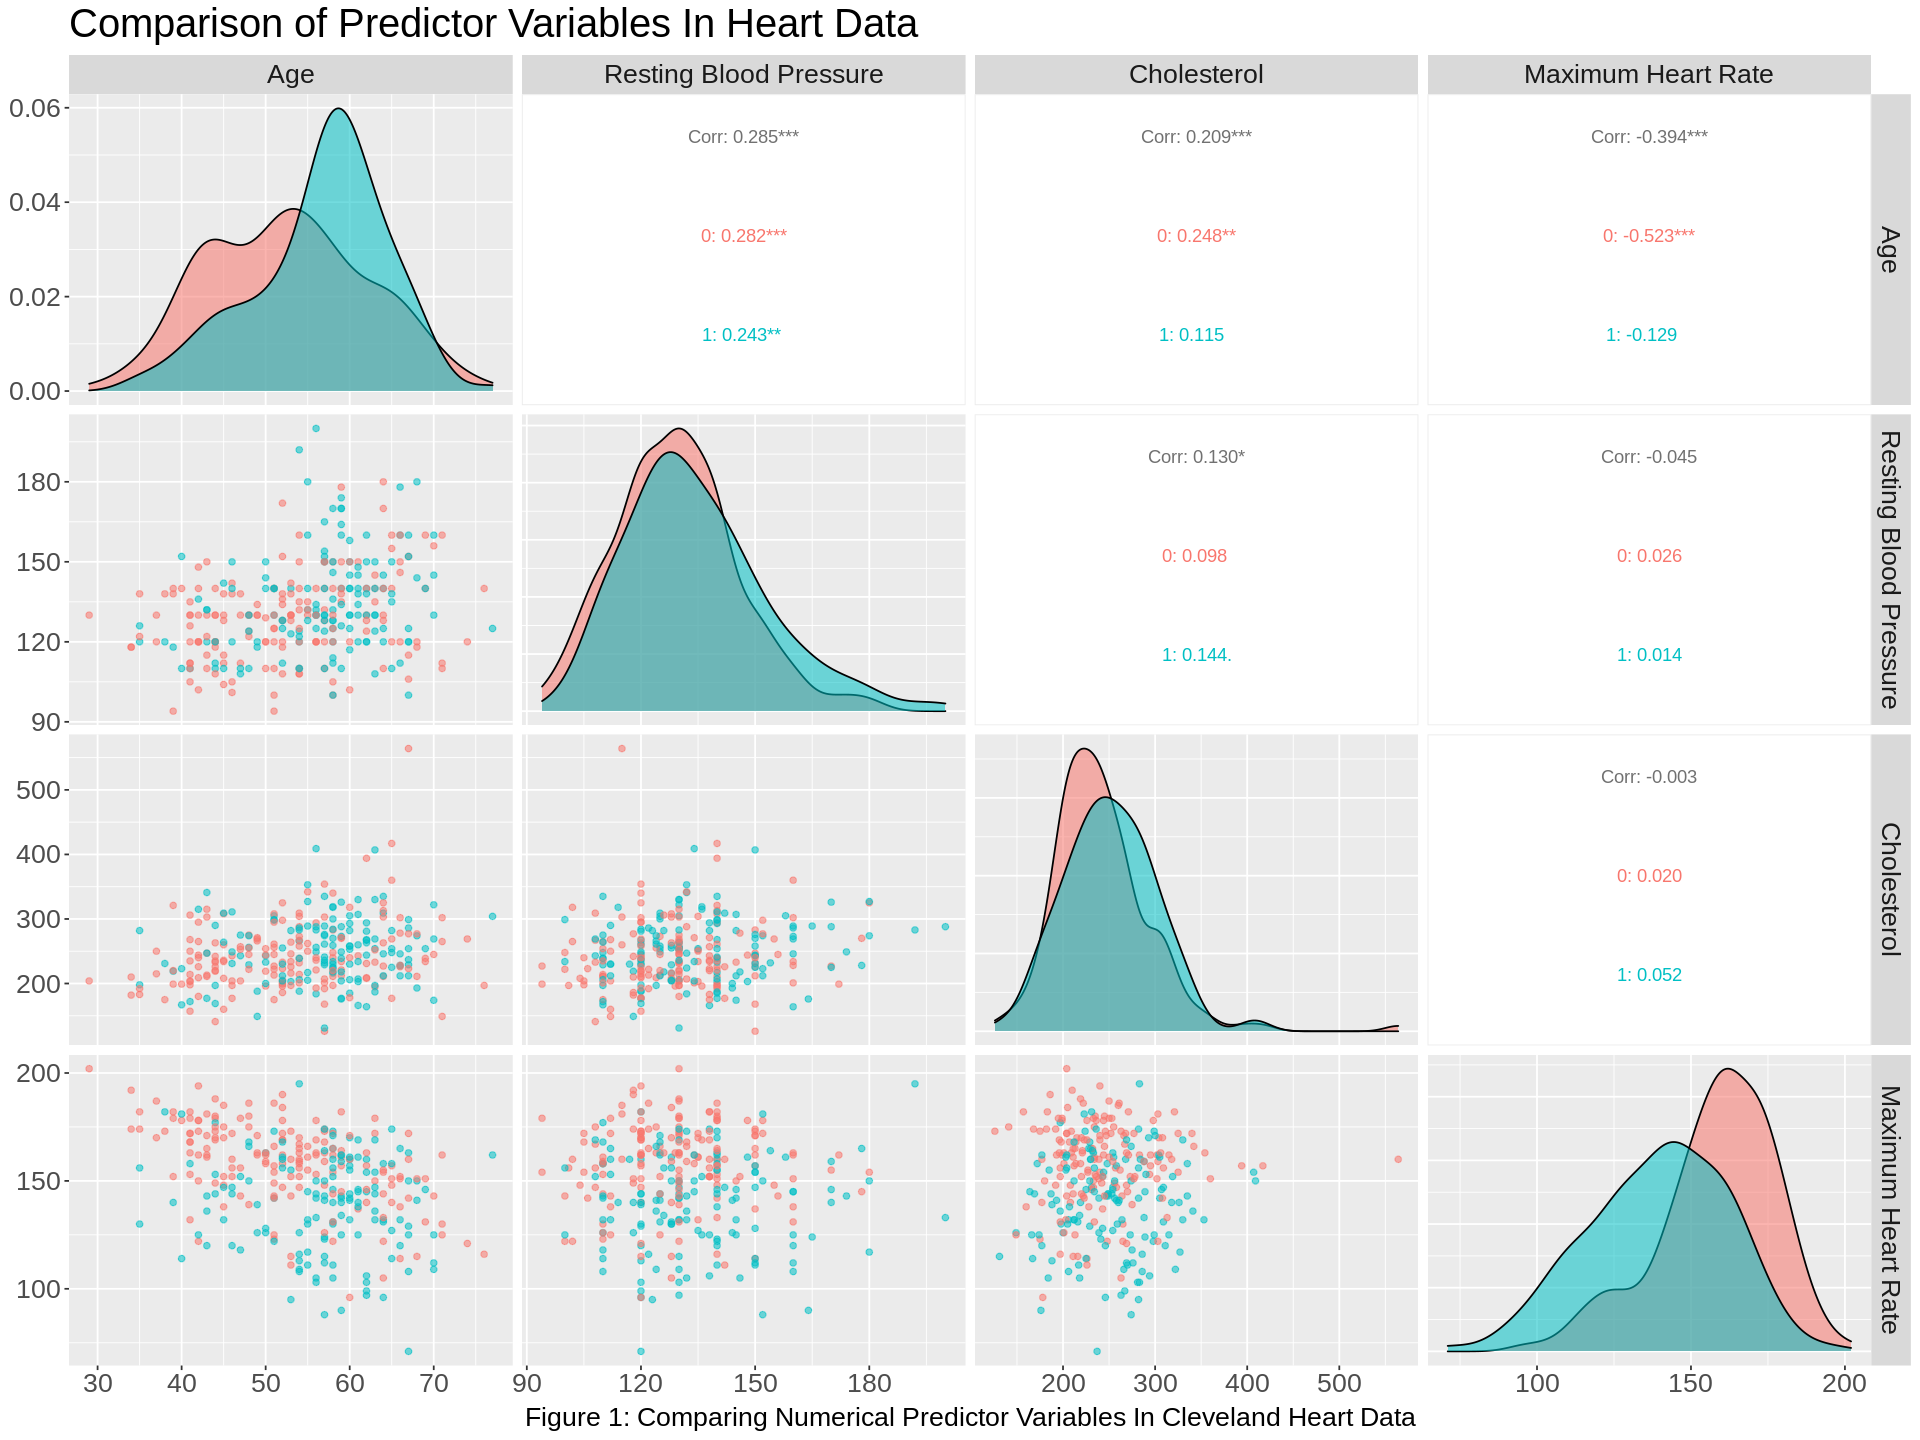

In [4]:
options(repr.plot.width = 16, repr.plot.height = 12)

# Select only numerical columns as well as response variable of num, indicating the condition of the patient (has heart disease or not)
heart_filtered <- heart_data |>
    select(age, trestbps, chol, thalach, num)

# Create more interpretable column names
colnames(heart_filtered) <- c("age", "rest_blood_pressure", "cholesterol", "max_heart_rate", "condition")

# Plot simple visualization to explore dataset
distribution_plot <- ggpairs(data = heart_filtered,
                            columns = 1:4,
                            aes(colour = condition, alpha = 0.6),
                            columnLabels = c("Age", "Resting Blood Pressure", "Cholesterol", "Maximum Heart Rate")) + 
        theme(text = element_text(size = 20)) +
        ggtitle("Comparison of Predictor Variables In Heart Data") + 
        labs(caption = "Figure 1: Comparing Numerical Predictor Variables In Cleveland Heart Data") + 
        theme(plot.caption = element_text(hjust = 0.5))
distribution_plot

The dataset contains a higher proportion of patients without heart disease compared to those with heart disease. Moreover, some predictors combined have little accuracy in determining whether a patient has heart disease or not, such as the scatter plot comparing maximum heart rate and cholesterol. The Pearson correlation index indicates the strength and direction between two variables. The highest Pearson correlation occurs when plotting maximum heart rate and age, and they have a negative relationship. Compared to other scatter plots, the distinction between those with heart disease and without is most prominent in this plot, indicating the potential for a relatively high accuracy model that can be trained using these two predictors. 

In fact, age and maximum heart rate have a natural relationship. According to the [Centers for Disease Control and Prevention](https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm) (2022), an individual's maximum heart rate should be 220 subtracted by their age, indicating a strong correlation between age and maximum heart rate. Furthermore, with aging, the heart's ability to pump blood to the rest of the body worsens as a result of simply overworking, buildup of fat deposits and increased stiffness ([National Institute on Aging](https://www.nia.nih.gov/health/heart-health-and-aging), 2018).

We will focus on age and maximum heart rate for our classification model.

In [5]:
# Compress the data so that it only contains the predictors we care about (age, maximum heart rate) and response variable of condition
heart <- heart_filtered |>
    select(age, max_heart_rate, condition)
head(heart)

age,max_heart_rate,condition
<dbl>,<dbl>,<fct>
63,150,0
67,108,1
67,129,1
37,187,0
41,172,0
56,178,0


Through the use of simple tables and calculations, we can better understand the relationship between our chosen predictors and overall dataset to look for any outliers or imbalances present within the dataset.

In [6]:
# Calculate the number of NA values present
na <- sum(is.na(heart))
na

[1] 0

We discover there are no NA values, so it is unnecessary to consider them. 

In [7]:
# Count number of those with and without heart disease
num_obs <- heart |>
    group_by(condition) |>
    summarize(count = n())
num_obs

condition,count
<fct>,<int>
0,164
1,139


From above, a condition of 0 indicates no heart disease, while a value of 1 indicates the presence of a heart disease. The data is relatively balanced between patients with and without heart disease, although there is a slight bias towards those without heart disease. Up sampling of those with heart disease could be possible, but is unnecessary.

In [8]:
means <- heart |>
    group_by(condition) |>
    summarize(across(age:max_heart_rate, mean))
means

condition,age,max_heart_rate
<fct>,<dbl>,<dbl>
0,52.58537,158.378
1,56.62590,139.259


We notice those with higher age and lower maximum heart rate tend to have heart disease. From the data, the mean average for age was around 57 years old for those with heart disease compared to 53 years old for those without. The maximum heart rate for those with heart disease was around 140 bpm, and around 158 bmp for those without. Let us focus on the graph corresponding to the relationship between age and maximum heart rate. 

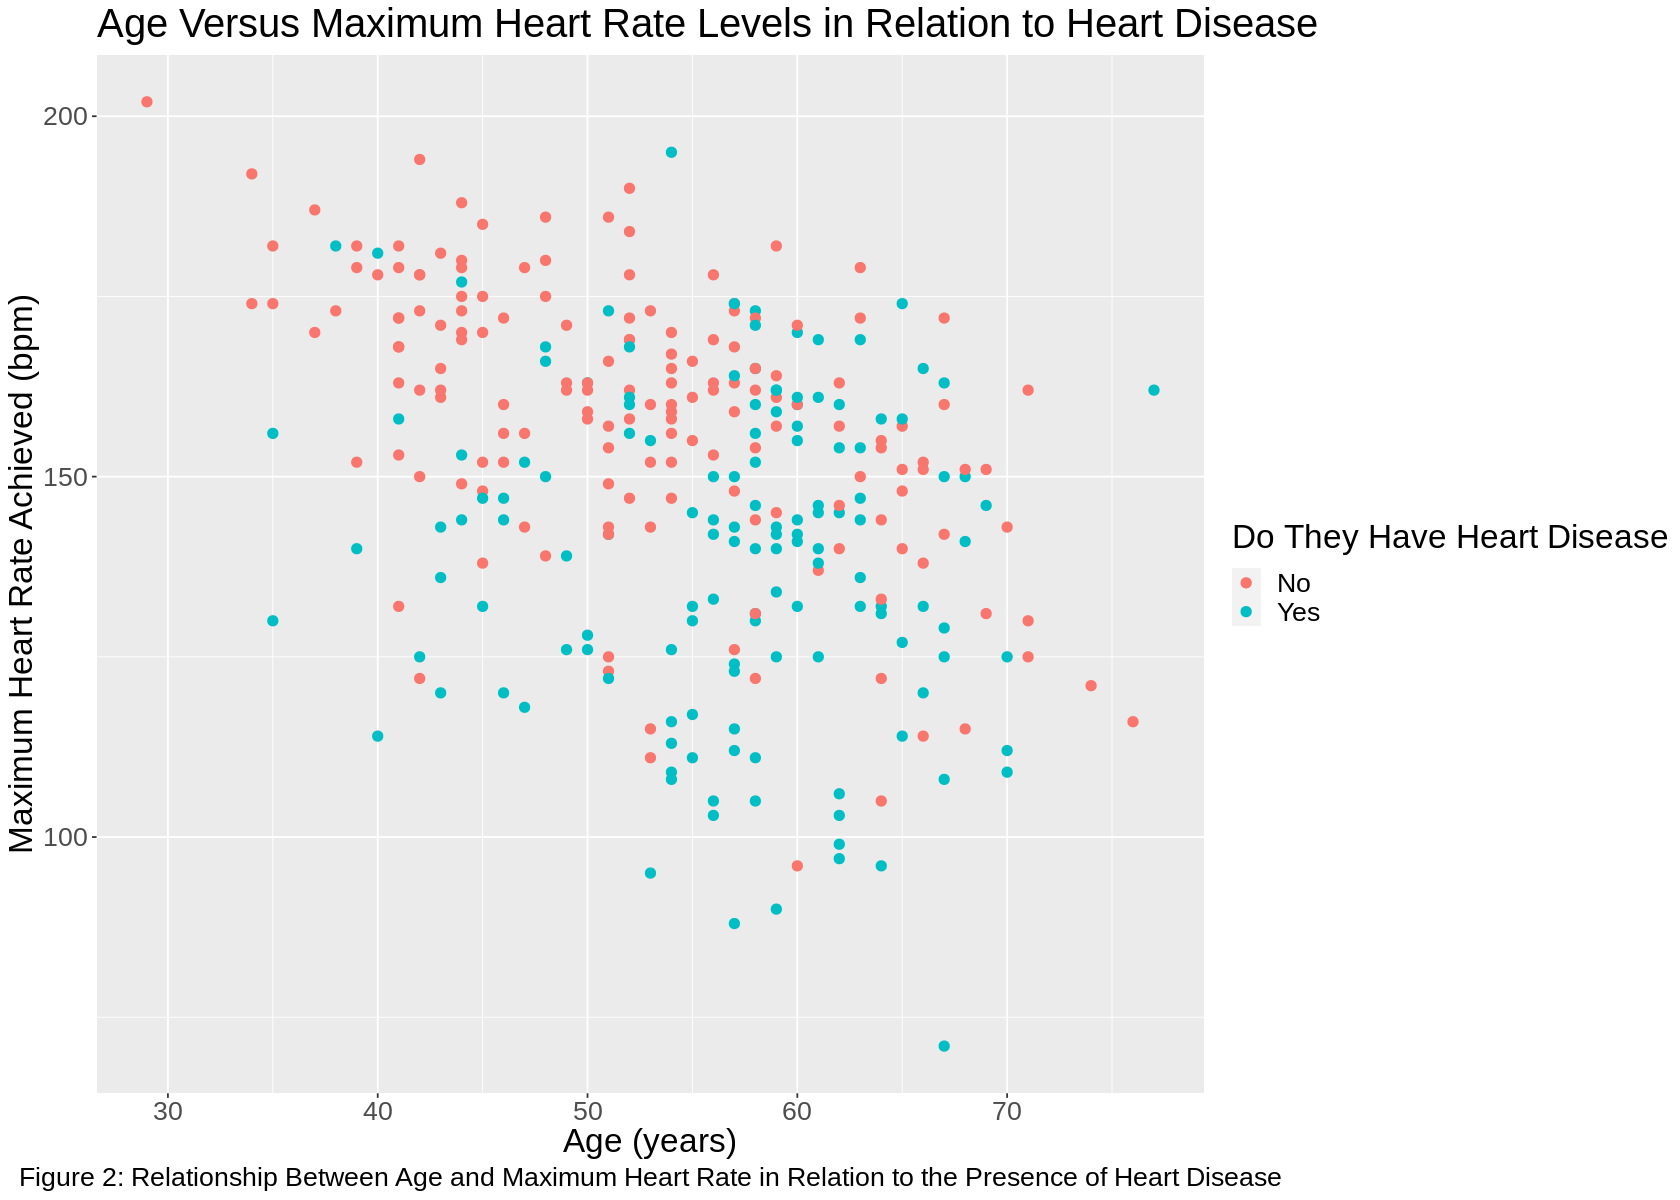

In [9]:
options(repr.plot.width = 14, repr.plot.height = 10)

heart_scatter <- heart |>
    ggplot(aes(x = age, y = max_heart_rate, color = condition)) +
    geom_point(size = 2.5) +
    xlab("Age (years)") +
    ylab("Maximum Heart Rate Achieved (bpm)") +
    labs(color = "Do They Have Heart Disease", 
         caption = "Figure 2: Relationship Between Age and Maximum Heart Rate in Relation to the Presence of Heart Disease") +
    ggtitle("Age Versus Maximum Heart Rate Levels in Relation to Heart Disease") +
    scale_color_discrete(labels = c("No", "Yes")) +
    theme(text = element_text(size = 20), 
          plot.caption = element_text(hjust = 0.5))
heart_scatter

Just like our table above, those with higher age and lower maximum heart rate seem to have a higher likelihood of having heart disease compared to the inverse, and we also take note of the negative relationship between both variables.

### Model Optimization

Now that we have explored the dataset thoroughly, chosen the predictor variables of age and maximum heart rate, and analyzed the relationship between these variables, we are ready to build our model. First, we set the seed to ensure that our data is reproducible, and split our data into a training and testing set, while ensuring that the data is shuffled and stratified for the condition label. We perform such steps because we would like to train our model on the training set, and then test its accuracy on the testing set. This is done so that we can judge the accuracy of our model as it makes new predictions on unseen data, so as to not overestimate its accuracy.

In [10]:
set.seed(1500)

# Splits our entire dataset into 75% training and 25% testing
heart_split <- initial_split(heart, prop = 0.75, strata = condition)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

After splitting our data into 75% training and 25% testing, we create a recipe for data preprocessing, where we center the data by subtracting each observation from the mean of that observation, and scale it by dividing by its standard deviation. This ensures that in our K-Nearest Neighbors algorithm, it uses the actual straight-line distance between each point without bias towards different scalings of the $x$ and $y$ axes. Following, we create our actual model specification to use for the algorithm, specifying the K-Nearest Neighbors algorithm for classification, where we are aiming to tune a value of `k` to use as the number of neighbors. To determine this value of `k`, we make a table of potential `k` values to test, and use 5-fold cross-validation to create 5 different models and test these values of `k` for each model to compute meaningful accuracy measurements. We ensure to set the stratification of these folds to the condition of the patient, to ensure that each fold has an equal amount of data for both conditions. We collect the results of these five different models after fitting each one to its respective fold from the cross-validation and filter for the accuracy measures that the models averaged out to have on the different values of `k` tested for. Note that these steps will only be carried out on the training data.

In [11]:
set.seed(1500)

# - Make a recipe with a formula predicting condition based on the predictors of
#   age and maximum heart rate achieved, using training data.
# - Standardize the data to ensure the scales are properly set for use 
#   of straight line distance in the K-nearest neighbors algorithm
heart_recipe <- recipe(condition ~ ., data = heart_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Create the model specification using Euclidean straight-line distance
# and tune the number of neighbors
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create the folds for 5-fold cross-validation
heart_vfold <- vfold_cv(heart_training, v = 5, strata = condition) 

# Create a table of neighbor values to test (tuning the k value)
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

# Compute statistics at different k values
heart_results <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    tune_grid(resamples = heart_vfold, grid = gridvals) |>
    collect_metrics()

# Discover the accuracy of the model at different values of k
accuracies <- heart_results |>
    filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5944181,5,0.02761267,Preprocessor1_Model01
6,accuracy,binary,0.6518138,5,0.02819976,Preprocessor1_Model02
11,accuracy,binary,0.6828415,5,0.02429520,Preprocessor1_Model03
16,accuracy,binary,0.6780018,5,0.03072141,Preprocessor1_Model04
21,accuracy,binary,0.6779051,5,0.03792100,Preprocessor1_Model05
26,accuracy,binary,0.6780018,5,0.03072141,Preprocessor1_Model06
31,accuracy,binary,0.6867896,5,0.03062973,Preprocessor1_Model07
36,accuracy,binary,0.6867852,5,0.03089944,Preprocessor1_Model08
41,accuracy,binary,0.6867896,5,0.02366662,Preprocessor1_Model09


We plot the accuracies at different values of `k` to visualize the optimal `k` value to use.

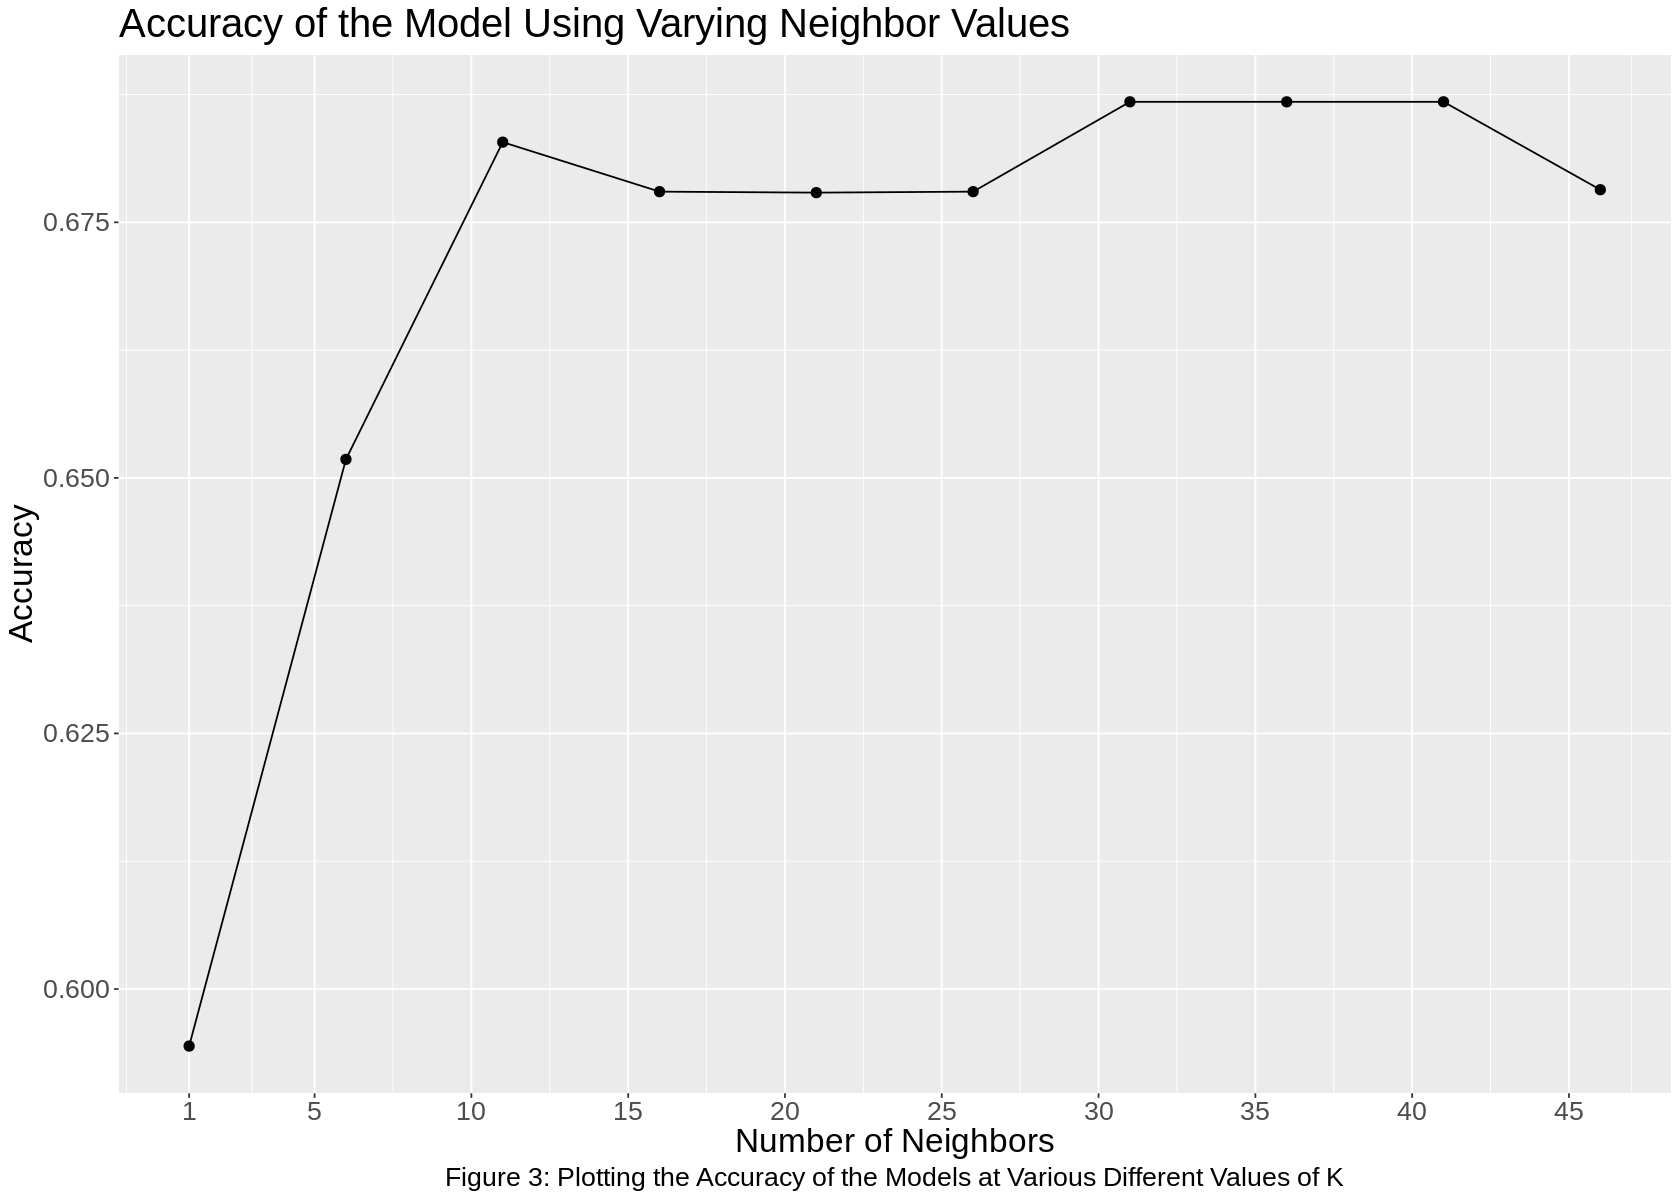

In [12]:
options(repr.plot.width = 14, repr.plot.height = 10)

# Plot of the accuracies at different values of k
accuracy_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) + 
    geom_point(size = 2.5) +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Accuracy", 
         title = "Accuracy of the Model Using Varying Neighbor Values", 
         caption = "Figure 3: Plotting the Accuracy of the Models at Various Different Values of K") + 
    scale_x_continuous(breaks = c(1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50)) +
    theme(text = element_text(size = 20), 
          plot.caption = element_text(hjust = 0.5))
accuracy_plot

The graph above represents the accuracy of the model at different `k` values, or number of neighbors. The graph reaches its first peak at 10 neighbors, and fluctuates about that point. Based on this, we choose a `k` value of 15 since it seems like increasing the neighbors from that point on does not make a significant difference in the accuracy of the model, and these accuracies themselves are estimates in the first place. As the number of neighbors increases to an absurd amount, the accuracy decreases due to extreme underfitting, where the model becomes unable to capture trends in the data. We choose the value of `k` to be slightly above the first peak to avoid possibility of overfitting, which occurs when the model captures too much noise in the dataset. 

Using our chosen value of `k` as 15, we construct a new model based on this value. Now, we make a new model specification using only the value of `k` extracted from the previous findings, and fit this model to the entire training set. Using this model, we pass in the testing set from the beginning so it can predict the condition of unseen patients.

In [13]:
# Using our analyzed best k value of 8 to retrain the model
heart_optimized <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_optimized) |>
    fit(heart_training) 

# use our retrained model with the best k value to predict values on the training set
predictions <- predict(heart_fit, heart_testing) |>
    bind_cols(heart_testing)

# get the statistics of our model's accuracy
results <- predictions |>
    metrics(truth = condition, estimate = .pred_class) |>
    filter(.metric == "accuracy")
results

# visualize the model predictions in a matrix
predictions |>
    conf_mat(truth = condition, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7631579


          Truth
Prediction  0  1
         0 33 10
         1  8 25

Our model had approximately 76% accuracy when predicting the condition of a patient in our testing set. As such, we would not be confident employing this model as a sole predictor for others to use in determining whether or not they have heart disease. The model made 58 correct predictions, which can be calculated by summing the amount of true positive (1 and 1) and true negative (0 and 0). Meanwhile, it had 8 counts of false positive, and 10 counts of false negative. In this case, a false negative is a worse outcome, because this means our model incorrectly predicted 10 people to be absent of heart disease, when in reality, they have it. The false positives account for 13% of the predictions, which can be considered fairly high for diagnosis of a terminal disease.

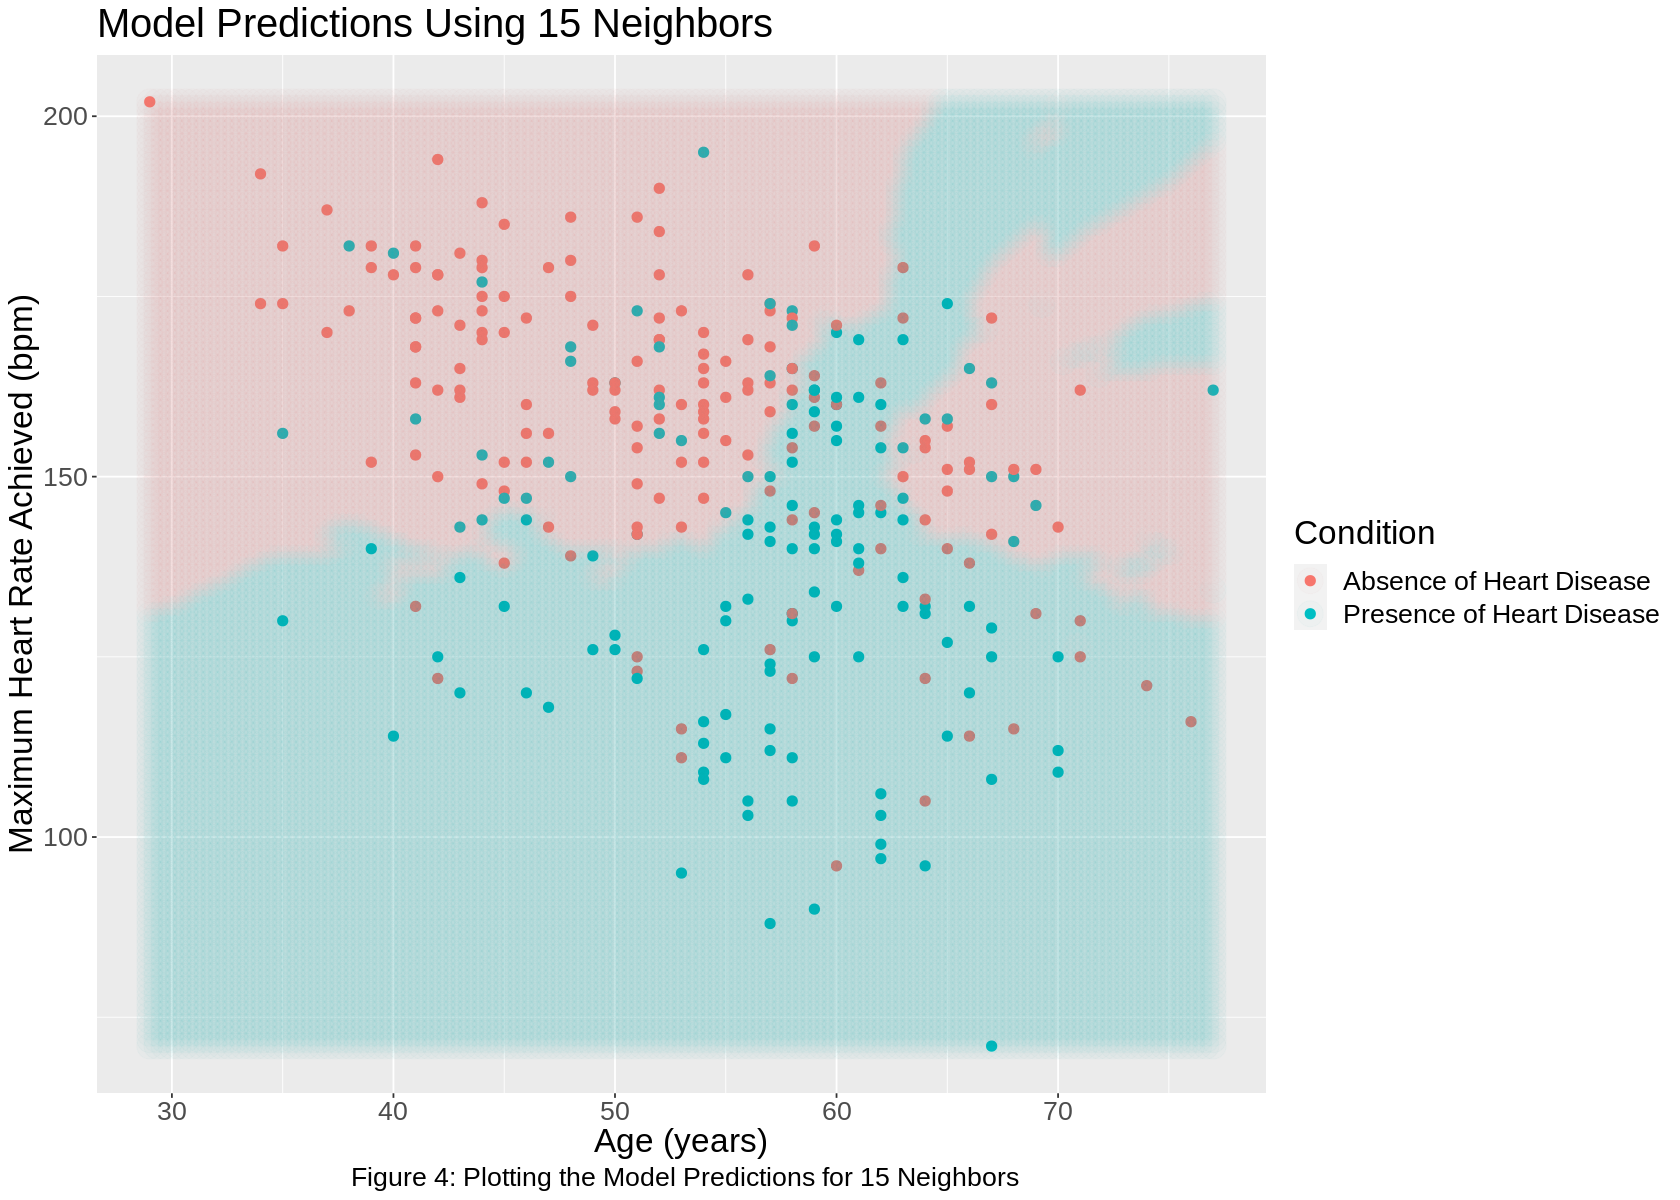

In [15]:
# A lot of boilerplate for this code is referenced from the textbook
options(repr.plot.width = 14, repr.plot.height = 10)

# create the grid of area/smoothness vals, and arrange in a data frame
age_grid <- seq(min(heart$age), 
                max(heart$age), 
                length.out = 150)
hr_grid <- seq(min(heart$max_heart_rate), 
               max(heart$max_heart_rate), 
               length.out = 150)
asgrid <- as_tibble(expand.grid(age = age_grid, 
                                max_heart_rate = hr_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(heart_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
    rename(condition = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
    ggplot() +
    geom_point(data = heart, 
               mapping = aes(x = age, 
                             y = max_heart_rate, 
                             color = condition), 
               size = 2.5) +
    geom_point(data = prediction_table, 
               mapping = aes(x = age, 
                             y = max_heart_rate, 
                             color = condition), 
               alpha = 0.02, 
               size = 7) +
    labs(color = "Condition", 
         x = "Age (years)", 
         y = "Maximum Heart Rate Achieved (bpm)",
         title = "Model Predictions Using 15 Neighbors", 
         caption = " Figure 4: Plotting the Model Predictions for 15 Neighbors") +
    scale_color_discrete(labels = c("Absence of Heart Disease", "Presence of Heart Disease")) +
    theme(text = element_text(size = 20), 
          plot.caption = element_text(hjust = 0.5))
wkflw_plot

We visualize the regions of area that our model would predict for a patient having or not having a heart disease. With 15 neighbors, the graph is well-fit, with a slight favour towards an overfit, as indicated by the presence of 'peninsulas' and jagged edges between the borders of either classification. 

# 3. Discussion

## Summary
<!-- summarize what you found. discuss whether this is what you expected to find? -->
Through our research in determining how well we can classify if a patient has a heart disease based on factors that can be more easily monitored at home, we discover that age and maximum heart rate have a high correlation with one another. Using these predictors to classify patients, we discover that on average, those with higher age and lower maximum heart rate are more at risk of heart disease. These findings align with what we expected, specifically, that those at a higher age are more likely to have a heart disease because the heart muscle has been worked for much longer, leading to inefficiencies and buildup of unwanted waste. On the other hand, lower maximum heart rate should correspond to a higher chance of having heart disease because the patient's heart cannot beat fast enough to pump blood to other parts of the body compared to those with a higher maximum heart rate, indicating that the heart may be strained or less effective. After training our model on the best value of `k`, we find that it has 76% accuracy, so we would not be confident employing this model as a primary method for determining whether or not someone has a heart disease, and should rather be used as a supplement to existing tests. Such tests could require the need to visit doctors periodically to more thoroughly check a patient's health.

## Significance
Our research aimed to classify if a patient has heart disease using factors that are easily monitorable, and such findings could have a great impact in reducing the amount of fatal heart disease problems. The predictors we use are all easily monitorable factors that do not require much external equipment to measure, so it is readily accessible by everyone to self diagnose. Maximum heart rate can be monitored through fitness watches and most fitness machines. However, our model only has an approximate 76% accuracy, and thus would not be entirely reliable to use as a sole indicator, and should be combined with other methods.

## Future Questions
Our research raises the question of, can our model become a mainsteam way for people to reliably test if they have a heart disease and seek more medical attention? Also, to ensure maximum accuracy of our model, we may consider adding other predictors that have a larger impact on the effects on heart disease, and potentially revise our current model to support these additions. Of course, we would like to maintain the aspect of the predictor being easily monitorable by anyone without the need to reach out to a specialist. We also recognize the limitations of employing a KNN algorithm for classification, so other variations could be considered. 

# 4. References

Centers for Disease Control and Prevention. (2022). Target heart Rate & Estimated Maximum Heart Rate. \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm


Government of Canada. (2022). Heart Disease in Canada. [https://www.canada.ca/en/public-](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html) \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[health/services/publications/diseases-conditions/heart-disease-canada.html](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html)


Janosi, A., Steinbrunn, W., Pfisterer, M., & Detrano, R. (1988). Heart Disease. *UCI Machine Learning Repository*. \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://archive.ics.uci.edu/dataset/45/heart+disease


National Institute on Aging. (2018). Heart Health and Aging. \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; https://www.nia.nih.gov/health/heart-health-and-aging